### Практическое задание. Урок 7

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [98]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd#; pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split

import xgboost
from sklearn.metrics import precision_recall_curve

In [99]:

# Чтение данных
df_data = pd.read_csv('HW_7_data/Qualitative_Bankruptcy.data.txt')

https://archive.ics.uci.edu/ml/datasets/Qualitative_Bankruptcy
<br>
  Title: Qualitative_Bankruptcy database<br>
      1. Industrial Risk: {P,A,N}<br>
      2. Management Risk: {P,A,N}<br>
      3. Financial Flexibility: {P,A,N}<br>
      4. Credibility: {P,A,N}<br>
      5. Competitiveness: {P,A,N}<br>
      6. Operating Risk: {P,A,N}<br>
      7. Class: {B,NB}<br>
   (P=Positive,A-Average,N-negative,B-Bankruptcy,NB-Non-Bankruptcy)<br>

In [100]:
df_data.rename(columns = {'P' : 'Industrial_Risk',
                          'P.1' : 'Management_Risk',
                          'A' : 'Financial_Flexibility',
                          'A.1' : 'Credibility',
                          'A.2' : 'Competitiveness',
                          'P.2' : 'Operating_Risk',
                          'NB' : 'Class'
                         }, inplace = True)

### Обзор датасета

In [101]:
print(df_data['Industrial_Risk'].value_counts())
print(df_data['Management_Risk'].value_counts())
print(df_data['Financial_Flexibility'].value_counts())
print(df_data['Credibility'].value_counts())
print(df_data['Competitiveness'].value_counts())
print(df_data['Operating_Risk'].value_counts())

N    89
A    81
P    79
Name: Industrial_Risk, dtype: int64
N    119
A     69
P     61
Name: Management_Risk, dtype: int64
N    119
A     73
P     57
Name: Financial_Flexibility, dtype: int64
N    94
P    79
A    76
Name: Credibility, dtype: int64
N    103
P     91
A     55
Name: Competitiveness, dtype: int64
N    114
P     78
A     57
Name: Operating_Risk, dtype: int64


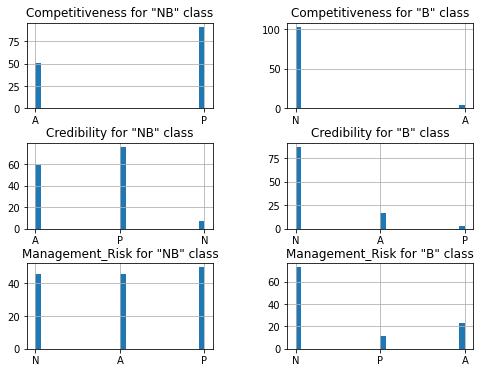

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.subplot (3, 2, 1)
df_data[df_data['Class']=='NB'].Competitiveness.hist(bins=30)
plt.title('Competitiveness for "NB" class')
plt.subplot (3, 2, 2)
df_data[df_data['Class']=='B'].Competitiveness.hist(bins=30)
plt.title('Competitiveness for "B" class')
plt.subplot (3, 2, 3)
df_data[df_data['Class']=='NB'].Credibility.hist(bins=30)
plt.title('Credibility for "NB" class')
plt.subplot (3, 2, 4)
df_data[df_data['Class']=='B'].Credibility.hist(bins=30)
plt.title('Credibility for "B" class')
plt.subplot (3, 2, 5)
df_data[df_data['Class']=='NB'].Management_Risk.hist(bins=30)
plt.title('Management_Risk for "NB" class')
plt.subplot (3, 2, 6)
df_data[df_data['Class']=='B'].Management_Risk.hist(bins=30)
plt.title('Management_Risk​ for "B" class')

plt.show()

### feature engineering
#### Признаки по сути категориальные, пропусков нет, feature engineering не очень здесь нужен, просто заменим символьные значения числовыми.

In [103]:
features_names = ('Industrial_Risk', 'Management_Risk', 'Financial_Flexibility', 'Credibility', 'Competitiveness', 'Operating_Risk')
for item in features_names:
    df_data[item].loc[(df_data[item]=='N')] = -1
    df_data[item].loc[(df_data[item]=='A')] = 0
    df_data[item].loc[(df_data[item]=='P')] = 1

df_data['Class'].loc[(df_data['Class']=='NB')] = 0
df_data['Class'].loc[(df_data['Class']!=0)] = 1
df_data.head()

,Industrial_Risk,Management_Risk,Financial_Flexibility,Credibility,Competitiveness,Operating_Risk,Class
0,-1,-1,0,0,0,-1,0
1,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0
3,-1,-1,1,1,1,-1,0
4,0,0,1,1,1,0,0


In [104]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_data['Class'], test_size=0.4, random_state=42)

In [105]:
y_train.to_numpy()
y_train.value_counts()
X_train=X_train.astype('int')
X_train=X_train.drop(['Class'], axis=1)
X_test=X_test.astype('int')
X_test=X_test.drop(['Class'], axis=1)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

summary_plot для всех данных


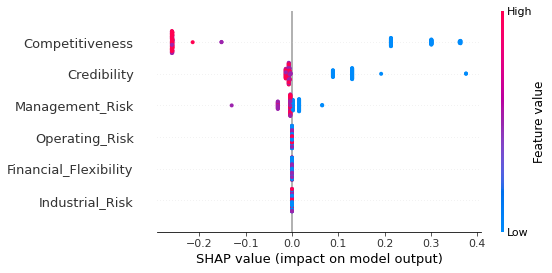

интерпретация: негативный класс здесь это отсутствие банкротства, на графике видим,
что высокие значения признаков Competitiveness, Credibility, Management Risk уменьшают
вероятность банкротства, а низкие - увеличивают. Остальные признаки влияют слабо
 
summary_plot для топ 10% данных


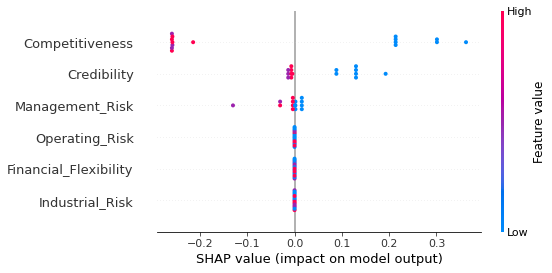

 
Важность признаков


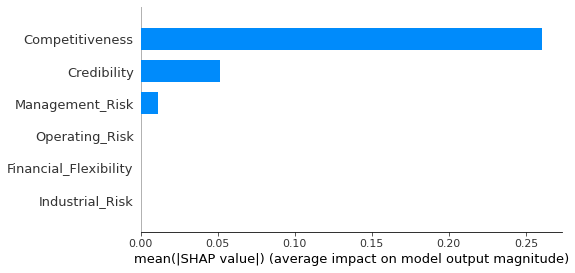

 
force_plot для наблюдения №64
интерпретация: в данном случае решение положительное, т.е. банкротство.
В основном на него повлияли низкие значения Competitiveness и Credibility
среднее значение Management Risk "попыталось" вытянуть ситуацию,
но важность и значения этого признака оказались недостаточными


In [106]:
and_state=42
classifier = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

import shap
shap.initjs()

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train)
print ('summary_plot для всех данных')
shap.summary_plot(shap_values, X_train)
print ('интерпретация: негативный класс здесь это отсутствие банкротства, на графике видим,')
print ('что высокие значения признаков Competitiveness, Credibility, Management Risk уменьшают')
print ('вероятность банкротства, а низкие - увеличивают. Остальные признаки влияют слабо')
print (' ')
print ('summary_plot для топ 10% данных')
shap.summary_plot(shap_values[:15,:], X_train.iloc[:15,:])

print (' ')
print ('Важность признаков')
shap.summary_plot(shap_values, X_train, plot_type="bar")

print (' ')
print ('force_plot для наблюдения №64')
print ('интерпретация: в данном случае решение положительное, т.е. банкротство.')
print ('В основном на него повлияли низкие значения Competitiveness и Credibility')
print ('среднее значение Management Risk "попыталось" вытянуть ситуацию,')
print ('но важность и значения этого признака оказались недостаточными')
shap.force_plot(explainer.expected_value, shap_values[64,:], X_train.iloc[64,:])
